In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import copy, time
import random 
import mfmodel as mfm

from scipy.linalg import pinvh
import mlrfit as mf 
import scipy.linalg as sc_la

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(1001)
random.seed(1001)

# True model is MLR factor model with SNR = 4 

Let $\Sigma = FF^T + D$ be MLR. We generate samples using 
$$
y = Fz + e, \qquad z \sim N(0, I), \qquad N(0, D).
$$

In [3]:
mtype = "small_mlr_hier"
n = 200
signal_to_noise = 4


L = 6

ranks = np.array([4, 3, 2, 2, 2, 1])
rank = ranks.sum()


nsamples = 4 * rank

In [4]:
pi_rows = np.random.permutation(n)
hpart = {'rows':{'pi':pi_rows, 'lk':[]}, 'cols':{'pi':pi_rows, 'lk':[]}} 
for ngroups in [2, 5, 17, 33, 65, n+1]:
       hpart['rows']['lk'] += [ np.linspace(0, n, ngroups, endpoint=True, dtype=int)]
hpart['rows']['lk'][1] = np.delete(hpart['rows']['lk'][1], -2)
hpart['rows']['lk'][2] = np.delete(hpart['rows']['lk'][2], -4)
hpart['cols']['lk'] = hpart['rows']['lk']
part_sizes = mfm.print_hpart_numgroups(hpart)

level=0, num_groups=1, mean_size=200.0
level=1, num_groups=3, mean_size=66.7
level=2, num_groups=15, mean_size=13.3
level=3, num_groups=32, mean_size=6.2
level=4, num_groups=64, mean_size=3.1
level=5, num_groups=200, mean_size=1.0


In [5]:
hpart['rows']['lk'][:-1]

[array([  0, 200]),
 array([  0,  50, 100, 200]),
 array([  0,  12,  25,  37,  50,  62,  75,  87, 100, 112, 125, 137, 150,
        175, 187, 200]),
 array([  0,   6,  12,  18,  25,  31,  37,  43,  50,  56,  62,  68,  75,
         81,  87,  93, 100, 106, 112, 118, 125, 131, 137, 143, 150, 156,
        162, 168, 175, 181, 187, 193, 200]),
 array([  0,   3,   6,   9,  12,  15,  18,  21,  25,  28,  31,  34,  37,
         40,  43,  46,  50,  53,  56,  59,  62,  65,  68,  71,  75,  78,
         81,  84,  87,  90,  93,  96, 100, 103, 106, 109, 112, 115, 118,
        121, 125, 128, 131, 134, 137, 140, 143, 146, 150, 153, 156, 159,
        162, 165, 168, 171, 175, 178, 181, 184, 187, 190, 193, 196, 200])]

In [6]:
true_mlr, true_sparse_F, true_D_noise = mfm.generate_mlr_model(n, hpart, ranks, signal_to_noise)
true_compressed_F = true_mlr.B[:, :-1]

signal_var=12.970723419787458, noise_var=3.2344552984255035
SNR=4.01017241638846, signal_to_noise=4


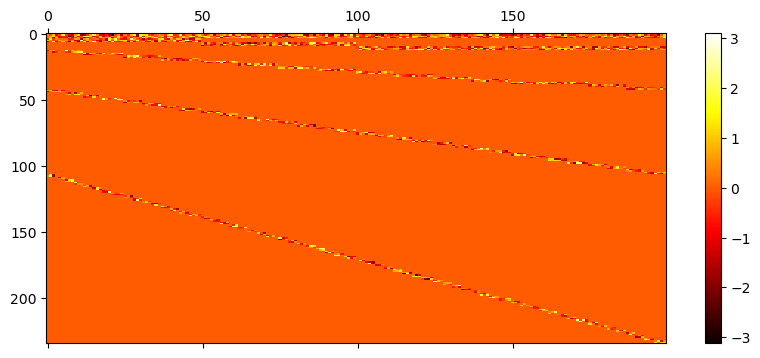

(200, 235)


In [7]:
plt.figure(figsize=(10, 4)) 
plt.matshow(true_sparse_F.T, aspect='auto', fignum=1, cmap='hot') 
plt.colorbar() 
plt.show()
print(true_sparse_F.shape)

In [8]:
type(true_sparse_F)

numpy.ndarray

In [9]:
filename = "%s_r%d_%d"%(mtype, rank, n)

In [10]:
row_selectors, si_groups, F_hpart, groups_all = mfm.row_col_selections(hpart, return_groups=True)

num_levels=6, num_sparsities=64
(64, 5) [ 0  2 14 31 63]


In [11]:
F_Lm1, D = true_compressed_F+0, true_D_noise+0

In [12]:
s_lps = np.cumsum(np.array([ranks[lp]*(F_hpart['lk'][lp].size - 1) for lp in reversed(range(0, L-1))]))
for l in reversed(range(0, L-1)):
    assert s_lps[l] == sum([ranks[lp]*(F_hpart['lk'][lp].size - 1) for lp in reversed(range(L-2-l, L-1))])

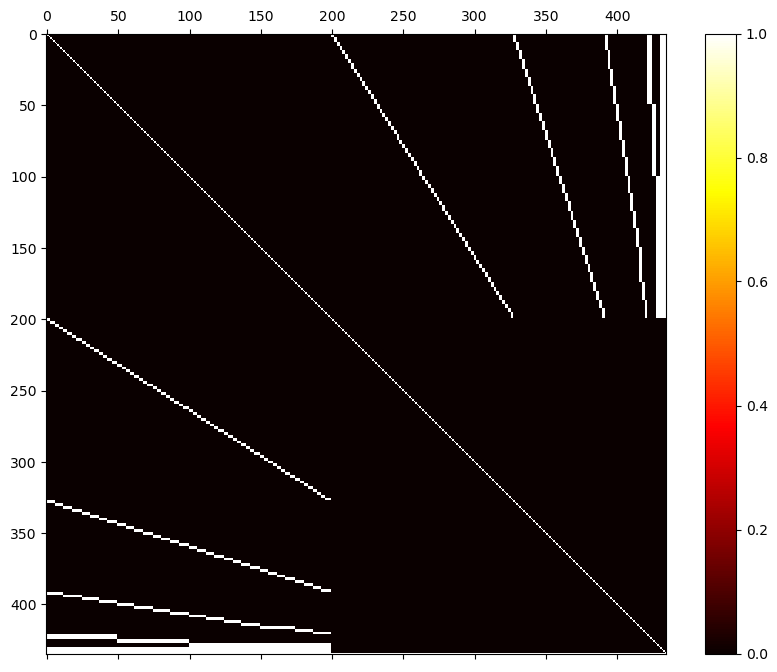

In [13]:
sparse_Fls = np.concatenate([mfm.block_diag_lk(F_hpart['lk'][lp], 
                                            F_Lm1[:, ranks[:lp].sum():ranks[:lp+1].sum()]) 
                                            for lp in reversed(range(0, L-1))], axis=1)
expanded_E = np.block([[np.diag(D), sparse_Fls],
              [sparse_Fls.T, -np.eye(s_lps[-1])]])


plt.figure(figsize=(10, 8)) 
plt.matshow(expanded_E!=0, aspect='auto', fignum=1, cmap='hot') 
plt.colorbar() 
plt.show()

In [14]:
assert np.allclose(true_sparse_F @ true_sparse_F.T, sparse_Fls @ sparse_Fls.T)

In [15]:
def lu(A):
    "Compute LU decomposition of matrix A."
    # from https://ubcmath.github.io/MATH307/notebooks/02_LU_decomposition.html
    m,n = A.shape
    L = np.eye(m)
    U = A.copy()
    # Keep track of the row index of the pivot entry
    pivot = 0
    for j in range(0,n):
        # Check if the pivot entry is 0
        if U[pivot,j] == 0:
            if np.any(U[pivot+1:,j]):
                # LU decomposition does not exist if entries below 0 pivot are nonzero
                print("LU decomposition for A does not exist.")
                return np.eye(m),A
            else:
                # All entries below 0 pivot are 0 therefore continue to next column
                # Row index of pivot remains the same
                continue
        # Use nonzero pivot entry to create 0 in each entry below
        for i in range(pivot+1,m):
            c = -U[i,j]/U[pivot,j]
            U[i,:] = c*U[pivot,:] + U[i,:]
            L[i,pivot] = -c
        # Move pivot to the next row
        pivot += 1
    return L,U


true_L, true_U = lu(expanded_E)
assert np.allclose(true_L @ true_U, expanded_E)

true_Chol_D = np.diag(true_U)
assert np.allclose((true_L * true_Chol_D) @ true_L.T, expanded_E) 

In [16]:
s_all = (ranks * np.array([hpart["rows"]["lk"][level].size-1 for level in range(L)]))[::-1]
s_all_1L = (ranks * np.array([hpart["rows"]["lk"][level].size-1 for level in range(L)]))
s_all    

array([200, 128,  64,  30,   9,   4])

In [17]:
sparse_Fls.shape, s_all, s_lps

((200, 235),
 array([200, 128,  64,  30,   9,   4]),
 array([128, 192, 222, 231, 235]))

In [18]:
prev_l_inv_recurrence = (1/D[:, np.newaxis]) * F_Lm1
H_Lm1 = np.zeros(F_Lm1.shape)
L = len(F_hpart['lk']) + 1

# cumulative sums: [p_{L-1} r_{L-1}, ... , p_{L-1} r_{L-1} + ... + p_1 r_1]
s_lps = np.cumsum(np.array([ranks[lp]*(F_hpart['lk'][lp].size - 1) for lp in reversed(range(0, L-1))]))
# for level L size: (r_1 + ... + r_{L-1}) x n
prev_DL_recurrence = F_Lm1.T * 1/D[np.newaxis, :]
Chol_L = [np.ones((1, n))] + [None] * (L-1)
# [np.zeros(ranks[lp], n + s_lps[lp]) for lp in reversed(range(0, L-1))]
Chol_D = np.zeros(n + s_lps[L-2])
Chol_D[:n] = D

for level in reversed(range(0, L-1)):
    pl = F_hpart['lk'][level].size - 1
    rl = ranks[level]
    if rl == 0: continue
    # M0 same sparsity as Fl
    M0 = prev_l_inv_recurrence[:, -ranks[level]:]
    # M1 = M0.T @ rec_term, same sparsity as rec_term
    M1 = np.zeros((rl * pl, ranks[:level].sum()))
    for lp in range(level):
        M1[:, ranks[:lp].sum() : ranks[:lp+1].sum()] = mfm.mult_blockdiag_refined_AtB(M0, 
                                                                            F_hpart['lk'][level], 
                                                                            F_Lm1[:, ranks[:lp].sum():ranks[:lp+1].sum()], 
                                                                            F_hpart['lk'][lp])
    M1_lks = [np.searchsorted(F_hpart['lk'][level], lk_B, side='left') * rl for lk_B in F_hpart['lk'][:level]]

    # M2 = (I + Fl^T M0)^{-1}, blockdiagonal with pl blocks of size (rl x rl)
    FlTM0 = mfm.mult_blockdiag_refined_AtB(F_Lm1[:, ranks[:level].sum() : ranks[:level+1].sum()], 
                                    F_hpart['lk'][level], 
                                    M0, 
                                    F_hpart['lk'][level])

    M2 = np.zeros((pl*rl, rl))
    sqrt_M2 = np.zeros((pl*rl, rl))
    for k in range(pl):
        np.fill_diagonal(FlTM0[k*rl : (k+1)*rl], FlTM0[k*rl : (k+1)*rl].diagonal() + 1)
        eigvals, eigvecs = np.linalg.eigh(FlTM0[k*rl : (k+1)*rl])
        sqrt_M2[k*rl : (k+1)*rl] = ((1 / np.sqrt(eigvals)) * eigvecs) @ eigvecs.T
        M2[k*rl : (k+1)*rl] = ((1/eigvals) * eigvecs) @ eigvecs.T
        del eigvals, eigvecs

    # Cholesky decomposition of M2^{-1}
    Chol_Rl = np.zeros((rl, pl*rl))
    Chol_Vl = np.zeros((pl*rl))
    for k in range(pl):
        Chol_Rl[:, k*rl : (k+1)*rl] = np.linalg.cholesky(FlTM0[k*rl : (k+1)*rl])
        Chol_Vl[k*rl : (k+1)*rl] = np.square(np.diag(Chol_Rl[:, k*rl : (k+1)*rl]))
        Chol_Rl[:, k*rl : (k+1)*rl] *= Chol_Vl[k*rl : (k+1)*rl]**(-1/2)

    # Cholesky new factors L^{(l)}, D^{(l)}
    Chol_L[L-1-level] = np.concatenate([prev_DL_recurrence[ranks[:level].sum():ranks[:level+1].sum(), :], Chol_Rl], axis=1)
    Chol_D[n + s_lps[L-2-level] - ranks[level]*(F_hpart['lk'][level].size - 1) : n + s_lps[L-2-level]] = -Chol_Vl 

    del FlTM0, Chol_Vl
    H_Lm1[:, ranks[:level].sum():ranks[:level+1].sum()] = mfm.mult_blockdiag_refined_AB(M0, 
                                                                                    F_hpart['lk'][level],
                                                                                    sqrt_M2, 
                                                                                    np.linspace(0, pl*rl, num=pl+1, endpoint=True, dtype=int))
    del sqrt_M2
    # M3 = M2 @ M1, same sparsity as M1
    M3 = np.zeros((rl * pl, ranks[:level].sum()))
    for lp in range(level):
        M3[:, ranks[:lp].sum():ranks[:lp+1].sum()] = mfm.mult_blockdiag_refined_AtB(M2, 
                                                                                    np.linspace(0, pl*rl, num=pl+1, endpoint=True, dtype=int), 
                                                                                    M1[:, ranks[:lp].sum():ranks[:lp+1].sum()], 
                                                                                    M1_lks[lp])
    del M1, M2

    if level >= 1:
        # (r_1 + ... + r_{l-1}) x (p_l r_l)
        M3TRl = np.zeros((ranks[:level].sum(), rl * pl))
        indices = np.linspace(0, pl*rl, num=pl+1, endpoint=True, dtype=int)
        for l_prime in range(level):
            rank1, rank2 = ranks[:l_prime].sum(), ranks[:l_prime+1].sum()
            M3TRl[rank1 : rank2] = mfm.mult_blockdiag_refined_CtB_vh(M3[:, rank1 : rank2], 
                                                M1_lks[l_prime],
                                                Chol_Rl, 
                                                indices)
        # Cholesky recurrent term
        # (r_1 + ... + r_{l-1}) x (n + p_{L-1} r_{L-1} + ... + p_l r_l)
        prev_DL_recurrence = np.concatenate([prev_DL_recurrence[:ranks[:level].sum(), :], M3TRl], axis=1)

            
    # M4 = M0 @ M3, same sparsity as current rec_term
    M4 = np.zeros((n, ranks[:level].sum()))
    for lp in range(level):
        M4[:, ranks[:lp].sum() : ranks[:lp+1].sum()] = mfm.mult_blockdiag_refined_AB(M0, 
                                                                                    F_hpart["lk"][level], 
                                                                                    M3[:, ranks[:lp].sum():ranks[:lp+1].sum()], 
                                                                                    M1_lks[lp])
    del M0, M3

    # M5  
    prev_l_inv_recurrence = prev_l_inv_recurrence[:, :ranks[:level].sum()] - M4
    del M4

In [19]:
sparse_Chol_L = mfm.sparse_chol_factor(Chol_L, s_lps, s_all, hpart, L, n, ranks)

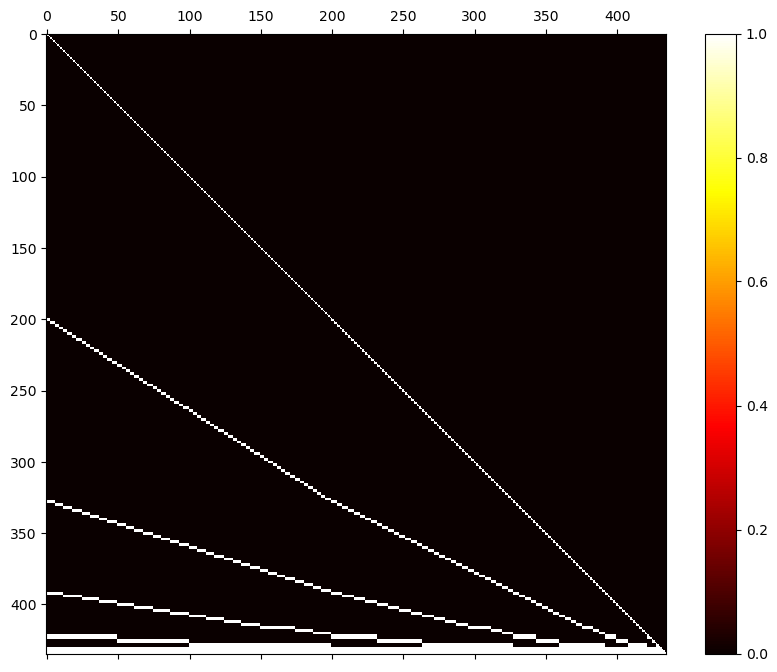

In [20]:
plt.figure(figsize=(10, 8)) 
plt.matshow(np.abs(sparse_Chol_L)[:]!=0, aspect='auto', fignum=1, cmap='hot') 
plt.colorbar() 
plt.show()

In [21]:
print(mf.rel_diff(expanded_E, (sparse_Chol_L * Chol_D) @ sparse_Chol_L.T))
assert (Chol_D > 0).sum() == n
assert np.allclose(expanded_E, (sparse_Chol_L * Chol_D) @ sparse_Chol_L.T)

1.788344705777104e-15


In [22]:
assert np.allclose(true_Chol_D, Chol_D)

In [23]:
F_hpart = {"pi": hpart['rows']["pi"], "lk": hpart['rows']["lk"][:-1]}
true_mfm = mfm.MFModel()

In [26]:
for _ in range(10):
    true_mfm = mfm.generate_mfmodel(true_mfm, n, F_hpart, ranks, signal_to_noise, debug=False)
    F_hpart["pi_inv"] = true_mfm.pi_inv

    true_mfm.inv_coefficients(cholesky=True)
    Chol_L, Chol_D = true_mfm.Chol_L, true_mfm.Chol_D


    sparse_Chol_L = mfm.sparse_chol_factor(Chol_L, s_lps, s_all, hpart, L, n, ranks)
    sparse_Fls = np.concatenate([mfm.block_diag_lk(F_hpart['lk'][lp], 
                                                true_mfm.F[:, ranks[:lp].sum():ranks[:lp+1].sum()]) 
                                                for lp in reversed(range(0, L-1))], axis=1)
    expanded_E = np.block([[np.diag(true_mfm.D), sparse_Fls],
                [sparse_Fls.T, -np.eye(s_lps[-1])]])

    print(mf.rel_diff(expanded_E, (sparse_Chol_L * Chol_D) @ sparse_Chol_L.T))
    assert (Chol_D > 0).sum() == n
    assert np.allclose(expanded_E, (sparse_Chol_L * Chol_D) @ sparse_Chol_L.T)

    assert np.allclose(np.linalg.det(true_mfm.matrix()), true_mfm.determinant)

print("\nPASSED")

signal_var=15.71270142316888, noise_var=2.9763964200025748
SNR=4.279102379499329, signal_to_noise=4
2.3071727306800045e-14
signal_var=15.416576590537035, noise_var=3.147595887221864
SNR=3.8978894187538273, signal_to_noise=4
2.7945898233754522e-14
signal_var=15.814010707070807, noise_var=3.13490350106361
SNR=4.0444968088189714, signal_to_noise=4
4.506038574497618e-15
signal_var=16.041244156477884, noise_var=3.251385081364359
SNR=3.933664809013207, signal_to_noise=4
9.67506293689845e-15
signal_var=15.594873678110213, noise_var=3.125319165345818
SNR=3.9898499490962007, signal_to_noise=4
3.367293905572473e-15
signal_var=16.23478594231714, noise_var=3.0671759922778405
SNR=4.293072840681817, signal_to_noise=4
3.322849596309923e-15
signal_var=15.965840917536077, noise_var=3.0379921591308294
SNR=4.255392404338499, signal_to_noise=4
6.769040531547749e-15
signal_var=16.151628478510105, noise_var=3.219331526825498
SNR=4.017075235627199, signal_to_noise=4
2.285202949055222e-15
signal_var=17.020005